In [1]:
import laspy as lp
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.neighbors import KDTree
from sklearn.mixture import GaussianMixture

def read_las_file(las_path):
    try:
        return lp.read(las_path)
    except Exception as e:
        print(f"Error reading {las_path}: {e}")
        return None

def normalize_colors(colors):
    rgba = colors - colors.min(axis=0)
    rgba = rgba / rgba.max(axis=0)
    return (rgba * 255).astype(np.uint8)

def normalize_points(points, eps= 1e-8):
    if not isinstance(points, np.ndarray) or points.shape[1] != 3:
        raise ValueError("points must be a numpy array with shape (n, 3).")
    points_ = points.copy()

    x_min, x_max = np.min(points_[:,0]), np.max(points_[:,0])
    y_min, y_max = np.min(points_[:,1]), np.max(points_[:,1])
    z_min, z_max = np.min(points_[:,2]), np.max(points_[:,2])

    points_[:,0] = (points_[:,0] - x_min) / (x_max - x_min + eps)
    points_[:,1] = (points_[:,1] - y_min) / (y_max - y_min + eps)
    points_[:,2] = (points_[:,2] - z_min) / (z_max - z_min + eps)
    
    return points_, x_min, x_max, y_min, y_max, z_min, z_max  

def get_points_and_colors(las_paths: list, limit: int = -1):
    if not isinstance(las_paths, list) or not all(isinstance(path, str) for path in las_paths):
        raise ValueError("las_paths must be a list of strings.")

    if not isinstance(limit, int) or limit < -1:
        raise ValueError("limit must be an integer greater than or equal to -1.")

    points = []
    colors = []
    classes = []

    for las_path in las_paths:
        las = read_las_file(las_path)
        if las is not None:
            points.append(np.vstack((las.x, las.y, las.z)).transpose())
            colors.append(np.vstack((las.red, las.green, las.blue)).transpose())
            classes.append(las.classification)

    if not points:
        raise ValueError("No valid LAS files found.")

    points = np.vstack(points)
    colors = np.vstack(colors)
    classes = np.hstack(classes)

    if limit > 0:
        idxs = np.random.choice(len(points), limit, replace=False)
        points = points[idxs]
        colors = colors[idxs]
        classes = classes[idxs]

    rgba_colors = normalize_colors(colors)

    return points, colors, rgba_colors, classes


def get_neighborhood(kdtree, point_idx, radius):
    indices = kdtree.query_radius([kdtree.data[point_idx]], r=radius)
    return indices[0]

def automatic_gmm_components(data, max_components=2, criterion='aic', T=0.1, **kwargs):
    n_components_range = range(1, max_components + 1)
    criterions, means = [], []
    if criterion not in ['aic', 'bic']:
        raise ValueError("Criterio no válido. Usa 'bic' o 'aic'.")
    
    for n in n_components_range:
        try:
            gmm = GaussianMixture(n_components=n, **kwargs)
            gmm.fit(data)
            criterions.append(gmm.bic(data)) if criterion == 'bic' else criterions.append(gmm.aic(data))
            means.append(gmm.means_)
            
        except ValueError as e:
            print(f"Error fitting GMM with {n} components: {e}")
            break

    optimal_idx = np.argmin(criterions)
    optimal_means = means[optimal_idx]
    optimal_components = n_components_range[optimal_idx]
    
    if optimal_components == 2 and abs(optimal_means[0] - optimal_means[1]) <= T:
       return 1, [np.mean(optimal_means, dtype=np.float32)]
    
    if not criterions:
        return 1, [np.mean(data, dtype=np.float32)]  # Si no se pudo ajustar ningún modelo, devolver 1 componente
    
    return optimal_components, means[optimal_idx]

In [5]:
import os
import tempfile
from joblib import Parallel, delayed

def process_chunk(chunk_indices, mmap_filename, shape, dtype, neighborhood_size_r):
    points_norm = np.memmap(mmap_filename, dtype=dtype, mode='r', shape=shape)
    kdtree = KDTree(points_norm)
    chunk_results = []
    
    for i in chunk_indices:
        indices = get_neighborhood(kdtree, i, neighborhood_size_r)
        z_neighborhood = points_norm[indices, 2]
        
        if len(z_neighborhood) < 2:
            continue
            
        z_neighborhood = z_neighborhood.reshape(-1, 1)
        optimal_n_components, _ = automatic_gmm_components(z_neighborhood)
        
        chunk_results.append([
            points_norm[i, 0], 
            points_norm[i, 1], 
            points_norm[i, 2], 
            optimal_n_components
        ])
    
    return chunk_results

def main(points, neighborhood_size=1):
    
    # Configurar archivo temporal para memoria compartida
    temp_dir = tempfile.mkdtemp()
    mmap_filename = os.path.join(temp_dir, 'points.dat')
    fp = np.memmap(mmap_filename, dtype=points.dtype, mode='w+', shape=points.shape)
    fp[:] = points[:]
    del fp  # Liberar recursos y asegurar escritura
    
    # Configurar paralelización
    n_jobs = os.cpu_count()  # Usar todos los núcleos disponibles
    indices = np.arange(len(points))
    chunks = np.array_split(indices, n_jobs * 4)  # Dividir en más chunks para balanceo de carga
    
    # Procesar en paralelo
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(process_chunk)(
            chunk,
            mmap_filename,
            points.shape,
            points.dtype,
            neighborhood_size
        ) for chunk in tqdm(chunks, desc="Processing Chunks", position=0, leave=True) #chunks
    )
    
    # Limpiar y combinar resultados
    final_result = [item for sublist in results for item in sublist]
    
    # Limpiar archivos temporales
    try:
        os.remove(mmap_filename)
        os.rmdir(temp_dir)
    except Exception as e:
        print(f"Error limpiando archivos temporales: {e}")
    
    points_norm = np.array(final_result)
    points_, x_min, x_max, y_min, y_max, z_min, z_max = normalize_points(points_norm[:,:3])
    points_norm[:, :3] = points_
    
    return {
        'points': points,
        'points_norm': points_norm,
        'x_min': x_min,
        'x_max': x_max,
        'y_min': y_min,
        'y_max': y_max,
        'z_min': z_min,
        'z_max': z_max
    }

# Uso 
if __name__ == "__main__":
    NAME_PROJECT = 'pozarbs'
    PATH_PROJECT = f'../data/{NAME_PROJECT}' 
    LIMIT = -1

    las_paths = [f'{PATH_PROJECT}/{filename}' for filename in os.listdir(PATH_PROJECT) if filename.endswith('.las')]
    points, colors, rgba_colors, classes = get_points_and_colors([las_paths[0]], limit=LIMIT)

    data = main(points, neighborhood_size=0.4) 
    points_norm = data.get('points_norm', None)

    one_result = points_norm[np.where(points_norm[:,3] == 1)][:,:-1]
    two_result = points_norm[np.where(points_norm[:,3] == 2)][:,:-1]

Processing Chunks:  25%|██▌       | 16/64 [00:00<00:01, 39.05it/s]/home/yeriel/workspace/kauel/sqm_batimetria/notebooks/env/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
Processing Chunks:  25%|██▌       | 16/64 [00:13<00:01, 39.05it/s]/home/yeriel/workspace/kauel/sqm_batimetria/notebooks/env/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/yeriel/workspace/kauel/sqm_batimetria/notebooks/env/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/yeriel/worksp

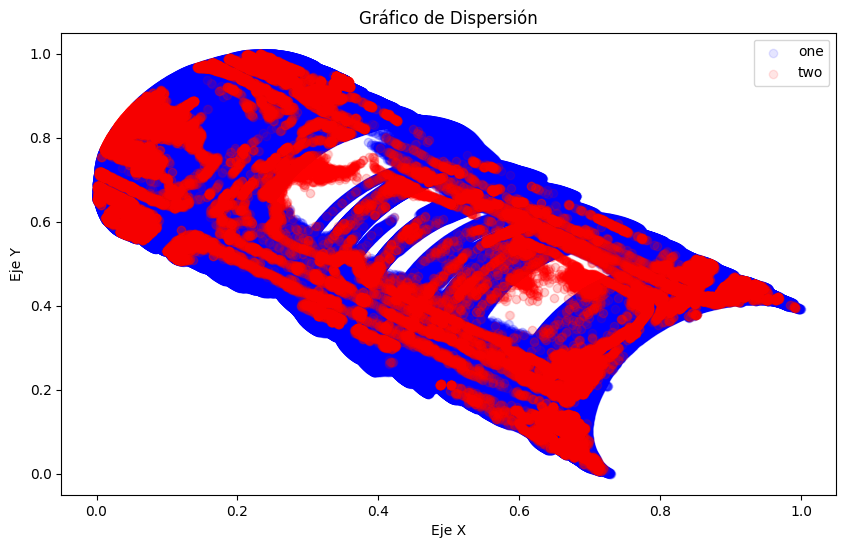

In [6]:
# Crear el gráfico 
plt.figure(figsize=(10, 6))
plt.scatter(one_result[:, 0], one_result[:, 1], color='blue', label='one', alpha=0.1)
plt.scatter(two_result[:, 0], two_result[:, 1], color='red', label='two', alpha=0.1)
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.title('Gráfico de Dispersión')
plt.legend()
plt.show()

In [4]:
import pyvista as pv

point_cloud = pv.PolyData(points)
# Add the RGBA colors to the point cloud as a scalar array
point_cloud["colors"] = rgba_colors

# Create the PyVista plotter
plotter = pv.Plotter()

# Add aligned coordinate axes
plotter.add_axes()

# Add the point cloud with colors
plotter.add_mesh(point_cloud, scalars="colors", rgb=True, pickable=True)

# List to store picked points
picked_points = []

# Callback function to handle point picking
def callback(point):
    # Add the picked point to the list
    picked_points.append(point)

    # If two points are picked, create a perpendicular plane
    if len(picked_points) == 2:
        # Extract the two points
        p1, p2 = picked_points

        # Compute the normal vector of the plane (vector between the points)
        normal = np.array(p2) - np.array(p1)
        # Rotate the normal vector by 90 degrees to get a perpendicular vector
        normal = np.array([normal[1], -normal[0], normal[2]])
        normal = normal / np.linalg.norm(normal)  # Normalize the vector

        # Compute the midpoint between the two points (center of the plane)
        midpoint = (np.array(p1) + np.array(p2)) / 2

        # Define the plane using PyVista's pv.Plane
        plane = pv.Plane(center=midpoint, direction=normal, i_size=100, j_size=1000)

        # Add the plane to the plotter
        plotter.add_mesh(plane, color="red", opacity=0.5, name="picked_plane")

        # Update the render window to display the new plane
        plotter.render()

        # Reset picked points for the next selection
        #picked_points.clear()

# Enable point picking and assign the callback
plotter.enable_point_picking(callback=callback, show_message=True)

# Show the plotter
plotter.show()

Widget(value='<iframe src="http://localhost:39971/index.html?ui=P_0x7a0158727d10_0&reconnect=auto" class="pyvi…